# Task 3: Correlation Analysis - News Sentiment vs. Stock Price Movements

## Project Context
This notebook performs comprehensive correlation analysis between financial news sentiment and stock price movements for **Nova Financial Solutions**. We establish quantifiable relationships between news sentiment and market behavior to develop actionable investment strategies.

### Objectives
1. **Data Alignment**: Merge news and stock data with proper date/timezone handling
2. **Sentiment Analysis**: Score headlines using NLP (TextBlob) to quantify market sentiment
3. **Returns Calculation**: Compute daily percentage returns for all stocks
4. **Correlation Analysis**: Calculate Pearson coefficients between sentiment and returns
5. **Predictive Testing**: Analyze lagged correlations (T+1, T+2) for forecasting power
6. **Investment Insights**: Develop actionable trading strategies based on findings

### Dataset Overview
- **News Data**: 1.4M+ financial news articles (2012-2020, UTC-4 timezone)
- **Stock Data**: 6 major tech stocks (AAPL, AMZN, GOOG, META, MSFT, NVDA)
- **Target Metric**: Pearson correlation >0.3 with statistical significance (p < 0.05)

## 1. Import Required Libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings

warnings.filterwarnings("ignore")

# Custom modules from src/core
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..", "src")))

from core.data_loader import DataLoader
from core.data_processor import DataProcessor
from core.sentiment_analyzer import SentimentAnalyzer
from core.financial_analyzer import FinancialAnalyzer
from core.visualizer import Visualizer

# Configure visualization
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
%matplotlib inline

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 2. Load and Validate Data

Load both news and stock datasets using the existing `DataLoader` module. We'll focus on a subset of stocks for correlation analysis to ensure statistical robustness.

In [2]:
# Initialize data loader
loader = DataLoader()

# Load news data
news_path = "../data/raw/raw_analyst_ratings.csv"
print("Loading news data...")
news_df = loader.load_news_data(news_path)

print(f"\n📊 News Dataset:")
print(f"  - Total articles: {len(news_df):,}")
print(f"  - Date range: {news_df['date'].min()} to {news_df['date'].max()}")
print(f"  - Unique stocks: {news_df['stock'].nunique()}")
print(f"  - Missing values: {news_df.isnull().sum().sum()}")

# Display sample
print("\nSample news data:")
news_df.head(3)

Loading news data...

📊 News Dataset:
  - Total articles: 1,407,328

📊 News Dataset:
  - Total articles: 1,407,328
  - Date range: 2009-02-14 00:00:00 to 2020-06-11 17:12:35-04:00
  - Unique stocks: 6204
  - Date range: 2009-02-14 00:00:00 to 2020-06-11 17:12:35-04:00
  - Unique stocks: 6204
  - Missing values: 0

Sample news data:
  - Missing values: 0

Sample news data:


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A


In [3]:
# Load stock data for selected symbols
stock_symbols = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"]
stock_data_dir = "../data/cleaned"

print("Loading stock data for:", stock_symbols)
stock_data = loader.load_multiple_stocks(
    data_directory=stock_data_dir, stock_symbols=stock_symbols
)

print(f"\n📈 Stock Datasets Loaded: {len(stock_data)} stocks")
for symbol, df in stock_data.items():
    print(
        f"  - {symbol}: {len(df)} trading days ({df.index.min().date()} to {df.index.max().date()})"
    )

# Display sample stock data
print("\nSample stock data (AAPL):")
stock_data["AAPL"].head(3)

Loading stock data for: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
✅ Loaded AAPL: 3774 records
✅ Loaded AMZN: 3774 records
✅ Loaded GOOG: 3774 records
✅ Loaded META: 2923 records
✅ Loaded MSFT: 3774 records
✅ Loaded AAPL: 3774 records
✅ Loaded AMZN: 3774 records
✅ Loaded GOOG: 3774 records
✅ Loaded META: 2923 records
✅ Loaded MSFT: 3774 records
✅ Loaded NVDA: 3774 records

📈 Stock Datasets Loaded: 6 stocks
  - AAPL: 3774 trading days (2009-01-02 to 2023-12-29)
  - AMZN: 3774 trading days (2009-01-02 to 2023-12-29)
  - GOOG: 3774 trading days (2009-01-02 to 2023-12-29)
  - META: 2923 trading days (2012-05-18 to 2023-12-29)
  - MSFT: 3774 trading days (2009-01-02 to 2023-12-29)
  - NVDA: 3774 trading days (2009-01-02 to 2023-12-29)

Sample stock data (AAPL):
✅ Loaded NVDA: 3774 records

📈 Stock Datasets Loaded: 6 stocks
  - AAPL: 3774 trading days (2009-01-02 to 2023-12-29)
  - AMZN: 3774 trading days (2009-01-02 to 2023-12-29)
  - GOOG: 3774 trading days (2009-01-02 to 2023-12-29)

,Close,High,Low,Open,Volume
Date,,,,,
2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400


## 3. Date Alignment and Dataset Merging

Use `DataProcessor` to normalize news timestamps (UTC-4) to trading days, handle weekends/holidays, and merge news with stock data by date and symbol.

In [6]:
# Reload the module to get the latest changes
import importlib

importlib.reload(sys.modules["core.data_processor"])
from core.data_processor import DataProcessor

# Initialize data processor
processor = DataProcessor()

# Filter news for our selected stocks
news_filtered = news_df[news_df["stock"].isin(stock_symbols)].copy()
print(
    f"Filtered news data: {len(news_filtered):,} articles for {len(stock_symbols)} stocks"
)

# Process and merge datasets
print("\n🔄 Processing and merging datasets...")
merged_df = processor.process_and_merge(
    news_df=news_filtered,
    stock_data=stock_data,
    news_date_column="date",
    stock_column="stock",
)

print(f"\n✅ Merge complete: {len(merged_df):,} records")
print(
    f"Date range: {merged_df['aligned_date'].min()} to {merged_df['aligned_date'].max()}"
)

# Validate merge quality
metrics = processor.validate_merge_quality(merged_df)
print("\n📊 Merge Quality Metrics:")
print(f"  - Unique dates: {metrics['unique_dates']}")
print(f"  - Unique stocks: {metrics['unique_stocks']}")
print(f"  - Records per stock:")
for stock, count in metrics["records_per_stock"].items():
    print(f"    * {stock}: {count:,}")

Filtered news data: 5,064 articles for 6 stocks

🔄 Processing and merging datasets...
Step 1: Normalizing news dates...
Step 2: Aligning with trading days...


Step 3: Merging news and stock data...
✅ Merge complete: 5064 records

✅ Merge complete: 5,064 records
Date range: 2011-03-03 00:00:00 to 2020-06-11 00:00:00

📊 Merge Quality Metrics:
  - Unique dates: 1223
  - Unique stocks: 4
  - Records per stock:
    * NVDA: 3,146
    * GOOG: 1,199
    * AAPL: 441
    * AMZN: 278
✅ Merge complete: 5064 records

✅ Merge complete: 5,064 records
Date range: 2011-03-03 00:00:00 to 2020-06-11 00:00:00

📊 Merge Quality Metrics:
  - Unique dates: 1223
  - Unique stocks: 4
  - Records per stock:
    * NVDA: 3,146
    * GOOG: 1,199
    * AAPL: 441
    * AMZN: 278


## 4. Sentiment Analysis on Headlines

Apply NLP sentiment analysis using `SentimentAnalyzer` with TextBlob to score all headlines. Calculate polarity scores (-1 to +1) and classify sentiment as positive/negative/neutral.

In [7]:
# Initialize sentiment analyzer
analyzer = SentimentAnalyzer(method="textblob")

# Analyze sentiment for all headlines
print("🔍 Analyzing sentiment for all headlines...")
sentiment_df = analyzer.analyze_dataframe(merged_df, text_column="headline")

print(f"\n✅ Sentiment analysis complete for {len(sentiment_df):,} headlines")

# Display sentiment distribution
sentiment_dist = analyzer.get_sentiment_distribution(sentiment_df)
print("\n📊 Overall Sentiment Distribution:")
print(f"  - Mean sentiment: {sentiment_dist['mean']:.4f}")
print(f"  - Median sentiment: {sentiment_dist['median']:.4f}")
print(f"  - Std deviation: {sentiment_dist['std']:.4f}")
print(f"  - Positive: {sentiment_dist['positive_pct']:.2f}%")
print(f"  - Negative: {sentiment_dist['negative_pct']:.2f}%")
print(f"  - Neutral: {sentiment_dist['neutral_pct']:.2f}%")

# Sample sentiment results
print("\nSample headlines with sentiment:")
sentiment_df[["headline", "sentiment_score", "sentiment_class", "symbol"]].head(5)

🔍 Analyzing sentiment for all headlines...
Analyzing sentiment for 5064 headlines...
✅ Sentiment analysis complete

✅ Sentiment analysis complete for 5,064 headlines

📊 Overall Sentiment Distribution:
  - Mean sentiment: 0.0640
  - Median sentiment: 0.0000
  - Std deviation: 0.1940
  - Positive: 28.65%
  - Negative: 9.48%
  - Neutral: 61.87%

Sample headlines with sentiment:
✅ Sentiment analysis complete

✅ Sentiment analysis complete for 5,064 headlines

📊 Overall Sentiment Distribution:
  - Mean sentiment: 0.0640
  - Median sentiment: 0.0000
  - Std deviation: 0.1940
  - Positive: 28.65%
  - Negative: 9.48%
  - Neutral: 61.87%

Sample headlines with sentiment:


,headline,sentiment_score,sentiment_class,symbol
0,Tech Stocks And FAANGS Strong Again To Start D...,0.433333,positive,AAPL
1,10 Biggest Price Target Changes For Wednesday,0.000000,neutral,AAPL
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",0.500000,positive,AAPL
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",0.000000,neutral,AAPL
4,Apple To Let Users Trade In Their Mac Computer...,0.000000,neutral,AAPL


In [9]:
# Aggregate daily sentiment by stock
print("📊 Aggregating daily sentiment scores by stock...")
daily_sentiment = analyzer.aggregate_daily_sentiment(
    sentiment_df, date_column="aligned_date", symbol_column="symbol"
)

print(f"✅ Aggregated to {len(daily_sentiment):,} daily records")
print(f"\nSample daily sentiment:")
daily_sentiment.head(10)

📊 Aggregating daily sentiment scores by stock...
✅ Aggregated to 1,588 daily records

Sample daily sentiment:
✅ Aggregated to 1,588 daily records

Sample daily sentiment:


,symbol,aligned_date,daily_sentiment,sentiment_std,sentiment_min,sentiment_max,article_count,positive_count,negative_count,neutral_count
0,AAPL,2020-03-09,-0.155556,0.269430,-0.466667,0.000000,3,0,1,2
1,AAPL,2020-03-10,0.021708,0.178692,-0.350000,0.260000,8,3,1,4
2,AAPL,2020-03-11,0.018624,0.102473,-0.155556,0.214286,14,4,3,7
3,AAPL,2020-03-12,-0.083048,0.528303,-1.000000,0.333333,5,3,1,1
4,AAPL,2020-03-13,0.069215,0.152159,0.000000,0.500000,11,3,0,8
5,AAPL,2020-03-16,0.082836,0.244449,-0.445833,0.500000,17,5,2,10
6,AAPL,2020-03-17,0.034673,0.100252,-0.083333,0.208333,12,4,3,5
7,AAPL,2020-03-18,0.104091,0.147936,-0.020000,0.300000,4,2,0,2
8,AAPL,2020-03-19,0.000000,0.000000,0.000000,0.000000,2,0,0,2
9,AAPL,2020-03-20,0.085417,0.120797,0.000000,0.170833,2,1,0,1


## 5. Calculate Stock Returns

Use `FinancialAnalyzer` to calculate daily percentage returns from closing prices using the formula: `(Close_today - Close_yesterday) / Close_yesterday * 100`

In [10]:
# Initialize financial analyzer
fin_analyzer = FinancialAnalyzer()

# Calculate returns for each stock
print("📈 Calculating daily returns for all stocks...")
stock_returns = {}

for symbol, stock_df in stock_data.items():
    returns = fin_analyzer.calculate_returns(stock_df, column="Close")
    stock_returns[symbol] = returns
    print(
        f"  - {symbol}: Mean return = {returns.mean():.4f}%, Std = {returns.std():.4f}%"
    )

# Combine returns with daily sentiment
correlation_data = []

for symbol in stock_symbols:
    # Get returns for this stock
    returns_series = stock_returns[symbol]
    returns_df = pd.DataFrame(
        {"Date": returns_series.index, "daily_return": returns_series.values}
    )
    returns_df["Date"] = pd.to_datetime(returns_df["Date"]).dt.normalize()

    # Get sentiment for this stock
    sentiment_for_stock = daily_sentiment[daily_sentiment["symbol"] == symbol].copy()
    sentiment_for_stock["aligned_date"] = pd.to_datetime(
        sentiment_for_stock["aligned_date"]
    ).dt.normalize()

    # Merge sentiment and returns
    merged = sentiment_for_stock.merge(
        returns_df, left_on="aligned_date", right_on="Date", how="inner"
    )
    merged["symbol"] = symbol
    correlation_data.append(merged)

# Combine all stocks
correlation_df = pd.concat(correlation_data, ignore_index=True)
print(
    f"\n✅ Combined dataset: {len(correlation_df):,} records with sentiment and returns"
)
print(f"\nSample correlation data:")
correlation_df[
    ["symbol", "aligned_date", "daily_sentiment", "daily_return", "article_count"]
].head(10)

📈 Calculating daily returns for all stocks...
  - AAPL: Mean return = 0.0013%, Std = 0.0180%
  - AMZN: Mean return = 0.0013%, Std = 0.0218%
  - GOOG: Mean return = 0.0009%, Std = 0.0173%
  - META: Mean return = 0.0011%, Std = 0.0253%
  - MSFT: Mean return = 0.0010%, Std = 0.0169%
  - NVDA: Mean return = 0.0019%, Std = 0.0289%

✅ Combined dataset: 1,588 records with sentiment and returns

Sample correlation data:

✅ Combined dataset: 1,588 records with sentiment and returns

Sample correlation data:


,symbol,aligned_date,daily_sentiment,daily_return,article_count
0,AAPL,2020-03-09,-0.155556,-0.079092,3
1,AAPL,2020-03-10,0.021708,0.072022,8
2,AAPL,2020-03-11,0.018624,-0.034730,14
3,AAPL,2020-03-12,-0.083048,-0.098755,5
4,AAPL,2020-03-13,0.069215,0.119808,11
5,AAPL,2020-03-16,0.082836,-0.128647,17
6,AAPL,2020-03-17,0.034673,0.043970,12
7,AAPL,2020-03-18,0.104091,-0.024480,4
8,AAPL,2020-03-19,0.000000,-0.007662,2
9,AAPL,2020-03-20,0.085417,-0.063485,2


## 6. Pearson Correlation Analysis

Calculate Pearson correlation coefficient between daily sentiment scores and daily stock returns. Assess statistical significance with p-values (target: p < 0.05).

In [14]:
# Calculate correlation for each stock
print("🔬 Calculating Pearson correlations by stock...\n")

correlation_results = []

for symbol in stock_symbols:
    stock_data_corr = correlation_df[correlation_df["symbol"] == symbol]

    if len(stock_data_corr) < 10:  # Need sufficient data points
        print(f"⚠️ {symbol}: Insufficient data ({len(stock_data_corr)} points)")
        continue

    # Calculate Pearson correlation
    corr_coef, p_value = pearsonr(
        stock_data_corr["daily_sentiment"], stock_data_corr["daily_return"]
    )

    correlation_results.append(
        {
            "Stock": symbol,
            "Correlation": corr_coef,
            "P-Value": p_value,
            "Significant": "Yes ✓" if p_value < 0.05 else "No ✗",
            "Sample_Size": len(stock_data_corr),
        }
    )

    significance = "SIGNIFICANT" if p_value < 0.05 else "not significant"
    print(f"{symbol}:")
    print(f"  - Correlation: {corr_coef:.4f}")
    print(f"  - P-value: {p_value:.6f} ({significance})")
    print(f"  - Sample size: {len(stock_data_corr)} days")
    print()

# Create results DataFrame
corr_results_df = pd.DataFrame(correlation_results)
print("\n📊 Correlation Summary:")
corr_results_df

🔬 Calculating Pearson correlations by stock...

AAPL:
  - Correlation: 0.1658
  - P-value: 0.201579 (not significant)
  - Sample size: 61 days

AMZN:
  - Correlation: -0.1022
  - P-value: 0.597807 (not significant)
  - Sample size: 29 days

GOOG:
  - Correlation: 0.0849
  - P-value: 0.111465 (not significant)
  - Sample size: 353 days

⚠️ META: Insufficient data (0 points)
⚠️ MSFT: Insufficient data (0 points)
NVDA:
  - Correlation: 0.0992
  - P-value: 0.000772 (SIGNIFICANT)
  - Sample size: 1145 days


📊 Correlation Summary:


,Stock,Correlation,P-Value,Significant,Sample_Size
0,AAPL,0.165807,0.201579,No ✗,61
1,AMZN,-0.102203,0.597807,No ✗,29
2,GOOG,0.084863,0.111465,No ✗,353
3,NVDA,0.099235,0.000772,Yes ✓,1145


## 7. Lagged Correlation Analysis

Test if today's sentiment predicts tomorrow's returns (predictive power). Analyze lag-1, lag-2, and lag-3 correlations to identify optimal prediction horizon.

In [15]:
# Calculate lagged correlations
print("⏰ Analyzing lagged correlations (T+1, T+2, T+3)...\n")

lagged_results = []

for symbol in stock_symbols:
    stock_data_lag = correlation_df[correlation_df["symbol"] == symbol].sort_values(
        "aligned_date"
    )

    if len(stock_data_lag) < 20:  # Need sufficient data
        continue

    # Calculate correlations for different lags
    lags = [1, 2, 3]
    lag_corrs = {"Stock": symbol, "Lag_0": None}

    # Lag 0 (same day)
    corr_0, p_0 = pearsonr(
        stock_data_lag["daily_sentiment"], stock_data_lag["daily_return"]
    )
    lag_corrs["Lag_0"] = corr_0
    lag_corrs["Lag_0_pval"] = p_0

    # Create lagged columns
    for lag in lags:
        # Shift returns by lag days (sentiment today vs. return in lag days)
        stock_data_lag[f"return_lag{lag}"] = stock_data_lag["daily_return"].shift(-lag)

        # Calculate correlation with lagged returns
        valid_data = stock_data_lag.dropna(subset=[f"return_lag{lag}"])

        if len(valid_data) >= 10:
            corr, p_val = pearsonr(
                valid_data["daily_sentiment"], valid_data[f"return_lag{lag}"]
            )
            lag_corrs[f"Lag_{lag}"] = corr
            lag_corrs[f"Lag_{lag}_pval"] = p_val
        else:
            lag_corrs[f"Lag_{lag}"] = None
            lag_corrs[f"Lag_{lag}_pval"] = None

    lagged_results.append(lag_corrs)

    # Print results for this stock
    print(f"{symbol}:")
    print(
        f"  - Lag 0 (same day):  r = {lag_corrs['Lag_0']:.4f}, p = {lag_corrs['Lag_0_pval']:.6f}"
    )
    if lag_corrs["Lag_1"] is not None:
        print(
            f"  - Lag 1 (T+1):       r = {lag_corrs['Lag_1']:.4f}, p = {lag_corrs['Lag_1_pval']:.6f}"
        )
    if lag_corrs["Lag_2"] is not None:
        print(
            f"  - Lag 2 (T+2):       r = {lag_corrs['Lag_2']:.4f}, p = {lag_corrs['Lag_2_pval']:.6f}"
        )
    if lag_corrs["Lag_3"] is not None:
        print(
            f"  - Lag 3 (T+3):       r = {lag_corrs['Lag_3']:.4f}, p = {lag_corrs['Lag_3_pval']:.6f}"
        )
    print()

# Create DataFrame
lag_results_df = pd.DataFrame(lagged_results)
print("\n📊 Lagged Correlation Summary:")
lag_results_df[["Stock", "Lag_0", "Lag_1", "Lag_2", "Lag_3"]]

⏰ Analyzing lagged correlations (T+1, T+2, T+3)...

AAPL:
  - Lag 0 (same day):  r = 0.1658, p = 0.201579
  - Lag 1 (T+1):       r = -0.1745, p = 0.182320
  - Lag 2 (T+2):       r = 0.1304, p = 0.324998
  - Lag 3 (T+3):       r = -0.0052, p = 0.968995

AMZN:
  - Lag 0 (same day):  r = -0.1022, p = 0.597807
  - Lag 1 (T+1):       r = -0.2479, p = 0.203340
  - Lag 2 (T+2):       r = 0.3434, p = 0.079483
  - Lag 3 (T+3):       r = -0.0645, p = 0.754348

GOOG:
  - Lag 0 (same day):  r = 0.0849, p = 0.111465
  - Lag 1 (T+1):       r = -0.0038, p = 0.942916
  - Lag 2 (T+2):       r = -0.0458, p = 0.392724
  - Lag 3 (T+3):       r = 0.0255, p = 0.634498

NVDA:
  - Lag 0 (same day):  r = 0.0992, p = 0.000772
  - Lag 1 (T+1):       r = -0.0216, p = 0.464853
  - Lag 2 (T+2):       r = 0.0333, p = 0.259954
  - Lag 3 (T+3):       r = 0.0056, p = 0.850860


📊 Lagged Correlation Summary:


,Stock,Lag_0,Lag_1,Lag_2,Lag_3
0,AAPL,0.165807,-0.174519,0.130379,-0.005217
1,AMZN,-0.102203,-0.247932,0.343398,-0.064474
2,GOOG,0.084863,-0.003830,-0.045759,0.025499
3,NVDA,0.099235,-0.021630,0.033347,0.005570


## 8. Visualization of Correlations

Create comprehensive visualizations to illustrate sentiment-return relationships: scatter plots, correlation heatmaps, and time series comparisons.

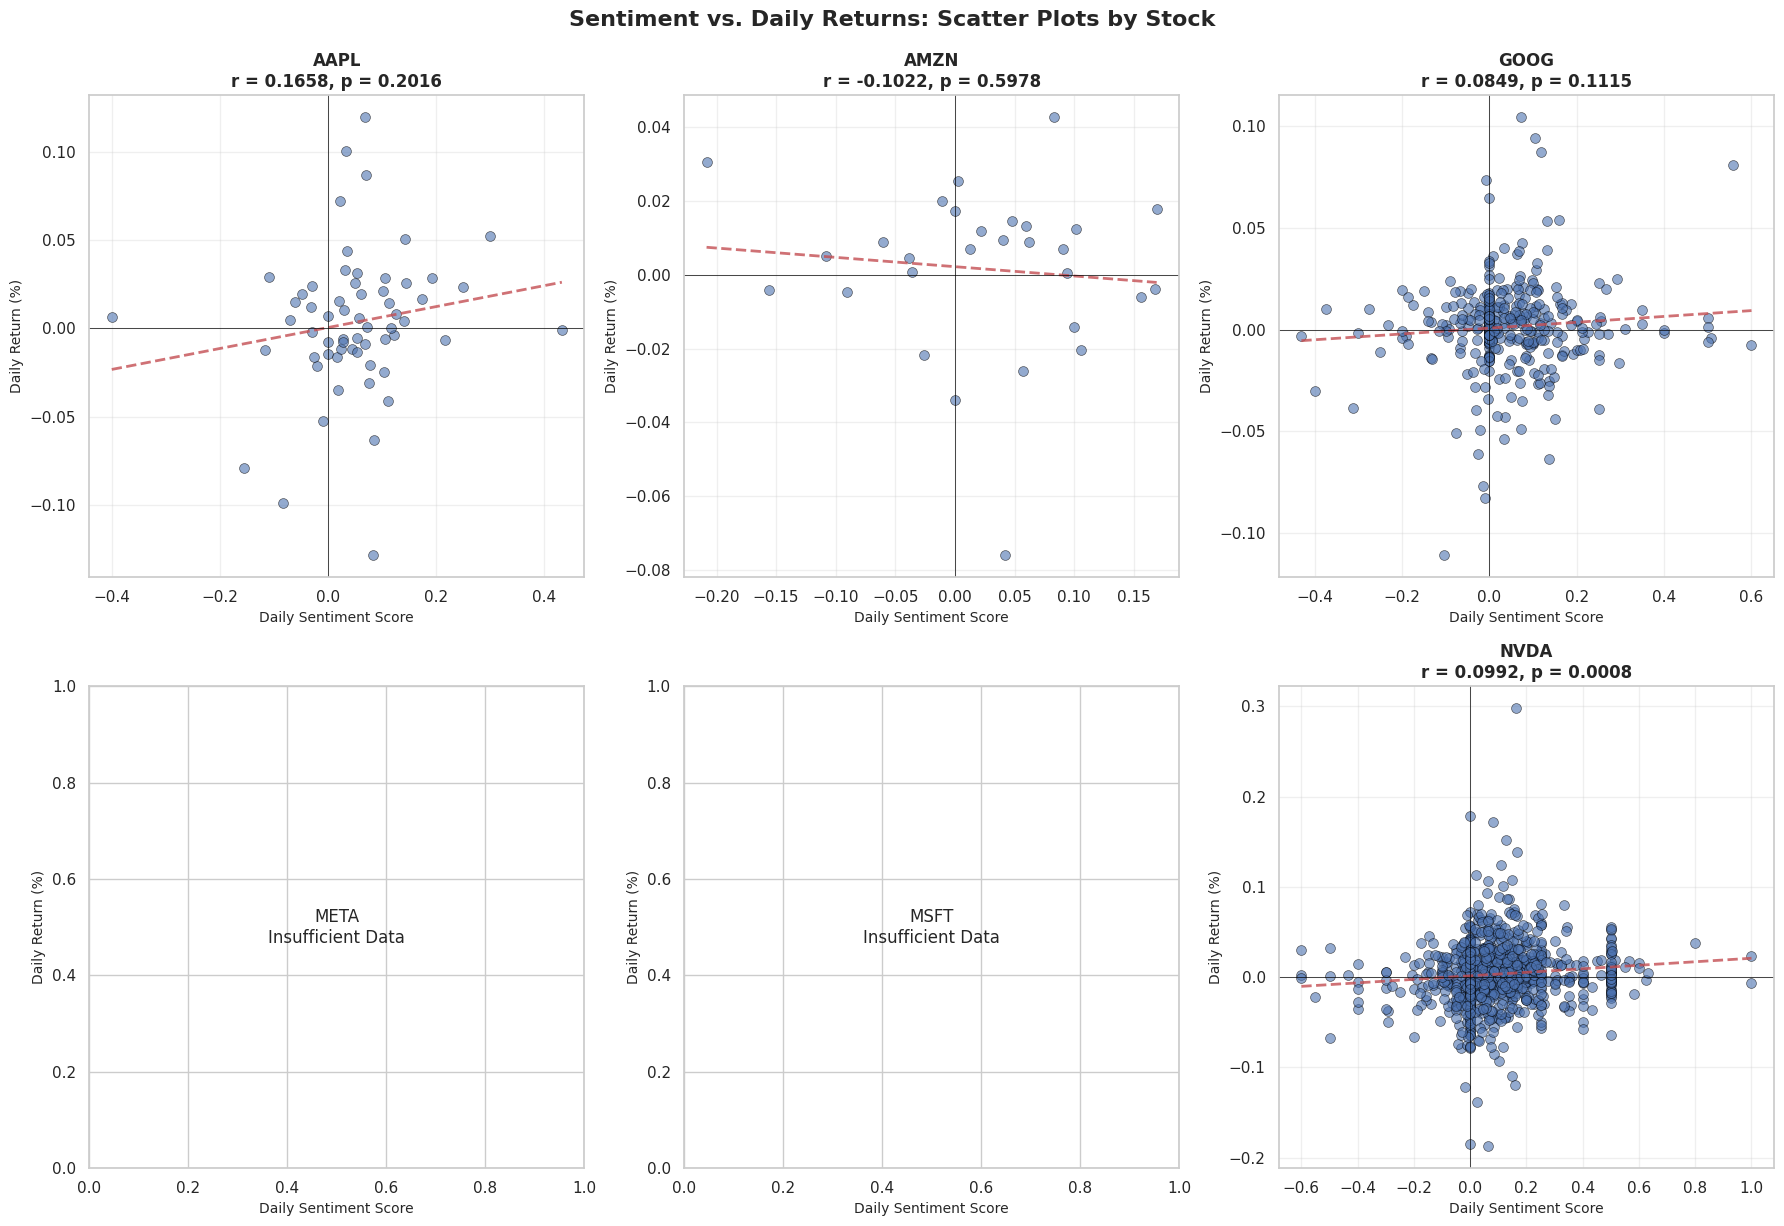

✅ Scatter plots generated


In [17]:
# Initialize visualizer
viz = Visualizer()

# 1. Scatter plots: Sentiment vs Returns by stock
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, symbol in enumerate(stock_symbols):
    stock_data_viz = correlation_df[correlation_df["symbol"] == symbol]

    # Skip if no data
    if len(stock_data_viz) == 0:
        axes[idx].text(
            0.5,
            0.5,
            f"{symbol}\nInsufficient Data",
            ha="center",
            va="center",
            fontsize=12,
            transform=axes[idx].transAxes,
        )
        axes[idx].set_xlabel("Daily Sentiment Score", fontsize=10)
        axes[idx].set_ylabel("Daily Return (%)", fontsize=10)
        continue

    axes[idx].scatter(
        stock_data_viz["daily_sentiment"],
        stock_data_viz["daily_return"],
        alpha=0.6,
        s=50,
        edgecolors="black",
        linewidth=0.5,
    )

    # Add regression line only if sufficient data
    if len(stock_data_viz) > 1:
        z = np.polyfit(
            stock_data_viz["daily_sentiment"], stock_data_viz["daily_return"], 1
        )
        p = np.poly1d(z)
        x_line = np.linspace(
            stock_data_viz["daily_sentiment"].min(),
            stock_data_viz["daily_sentiment"].max(),
            100,
        )
        axes[idx].plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8)

    # Get correlation
    corr_idx = [i for i, r in enumerate(correlation_results) if r["Stock"] == symbol]
    if corr_idx:
        corr = correlation_results[corr_idx[0]]["Correlation"]
        p_val = correlation_results[corr_idx[0]]["P-Value"]
    else:
        corr, p_val = 0, 1

    axes[idx].set_title(
        f"{symbol}\nr = {corr:.4f}, p = {p_val:.4f}", fontsize=12, fontweight="bold"
    )
    axes[idx].set_xlabel("Daily Sentiment Score", fontsize=10)
    axes[idx].set_ylabel("Daily Return (%)", fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    axes[idx].axvline(x=0, color="black", linestyle="-", linewidth=0.5)

plt.tight_layout()
plt.suptitle(
    "Sentiment vs. Daily Returns: Scatter Plots by Stock",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)
plt.show()

print("✅ Scatter plots generated")

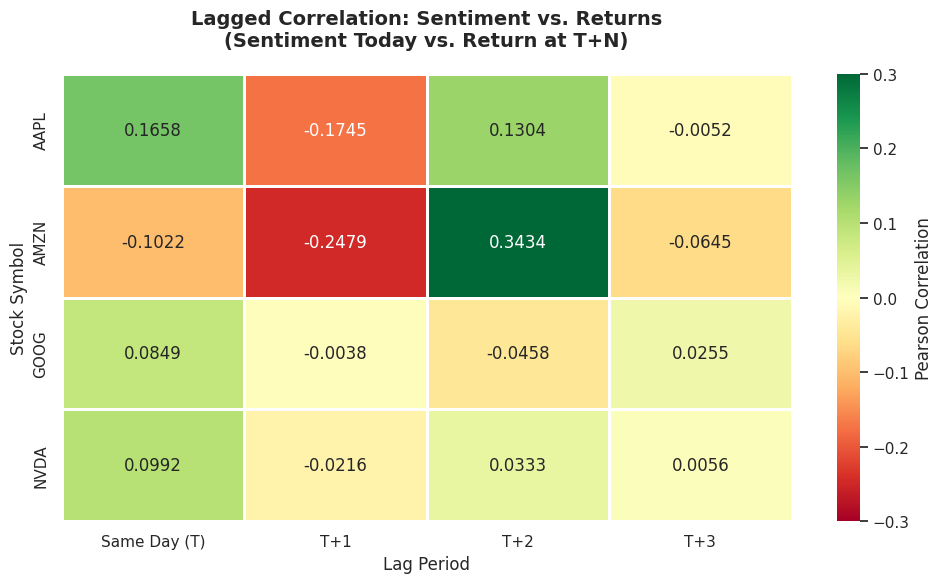

✅ Lag correlation heatmap generated


In [18]:
# 2. Correlation heatmap (lag analysis)
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for heatmap
heatmap_data = lag_results_df.set_index("Stock")[["Lag_0", "Lag_1", "Lag_2", "Lag_3"]]
heatmap_data.columns = ["Same Day (T)", "T+1", "T+2", "T+3"]

# Create heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="RdYlGn",
    center=0,
    vmin=-0.3,
    vmax=0.3,
    linewidths=1,
    linecolor="white",
    cbar_kws={"label": "Pearson Correlation"},
    ax=ax,
)

ax.set_title(
    "Lagged Correlation: Sentiment vs. Returns\n(Sentiment Today vs. Return at T+N)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Lag Period", fontsize=12)
ax.set_ylabel("Stock Symbol", fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Lag correlation heatmap generated")

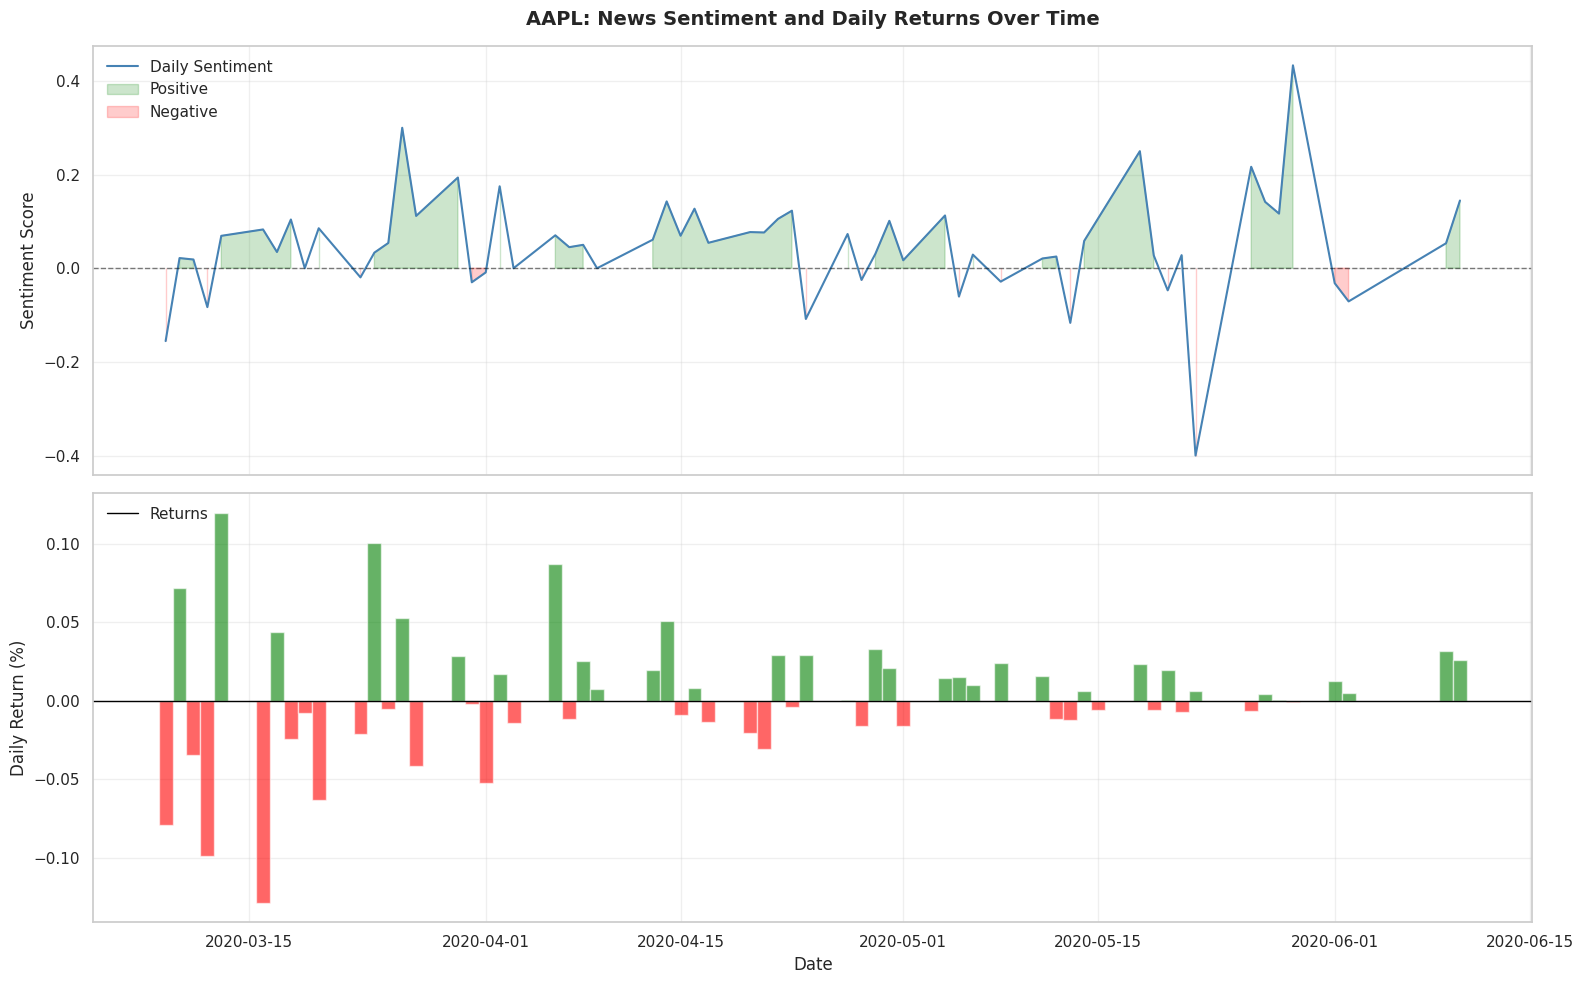

✅ Time series plot generated for AAPL


In [19]:
# 3. Time series: Sentiment and Returns (example for AAPL)
example_stock = "AAPL"
example_data = correlation_df[correlation_df["symbol"] == example_stock].sort_values(
    "aligned_date"
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Plot sentiment
ax1.plot(
    example_data["aligned_date"],
    example_data["daily_sentiment"],
    color="steelblue",
    linewidth=1.5,
    label="Daily Sentiment",
)
ax1.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.5)
ax1.fill_between(
    example_data["aligned_date"],
    0,
    example_data["daily_sentiment"],
    where=example_data["daily_sentiment"] > 0,
    color="green",
    alpha=0.2,
    label="Positive",
)
ax1.fill_between(
    example_data["aligned_date"],
    0,
    example_data["daily_sentiment"],
    where=example_data["daily_sentiment"] < 0,
    color="red",
    alpha=0.2,
    label="Negative",
)
ax1.set_ylabel("Sentiment Score", fontsize=12)
ax1.set_title(
    f"{example_stock}: News Sentiment and Daily Returns Over Time",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

# Plot returns
ax2.bar(
    example_data["aligned_date"],
    example_data["daily_return"],
    color=["green" if x > 0 else "red" for x in example_data["daily_return"]],
    alpha=0.6,
    width=1,
)
ax2.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Daily Return (%)", fontsize=12)
ax2.legend(["Returns"], loc="upper left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Time series plot generated for {example_stock}")

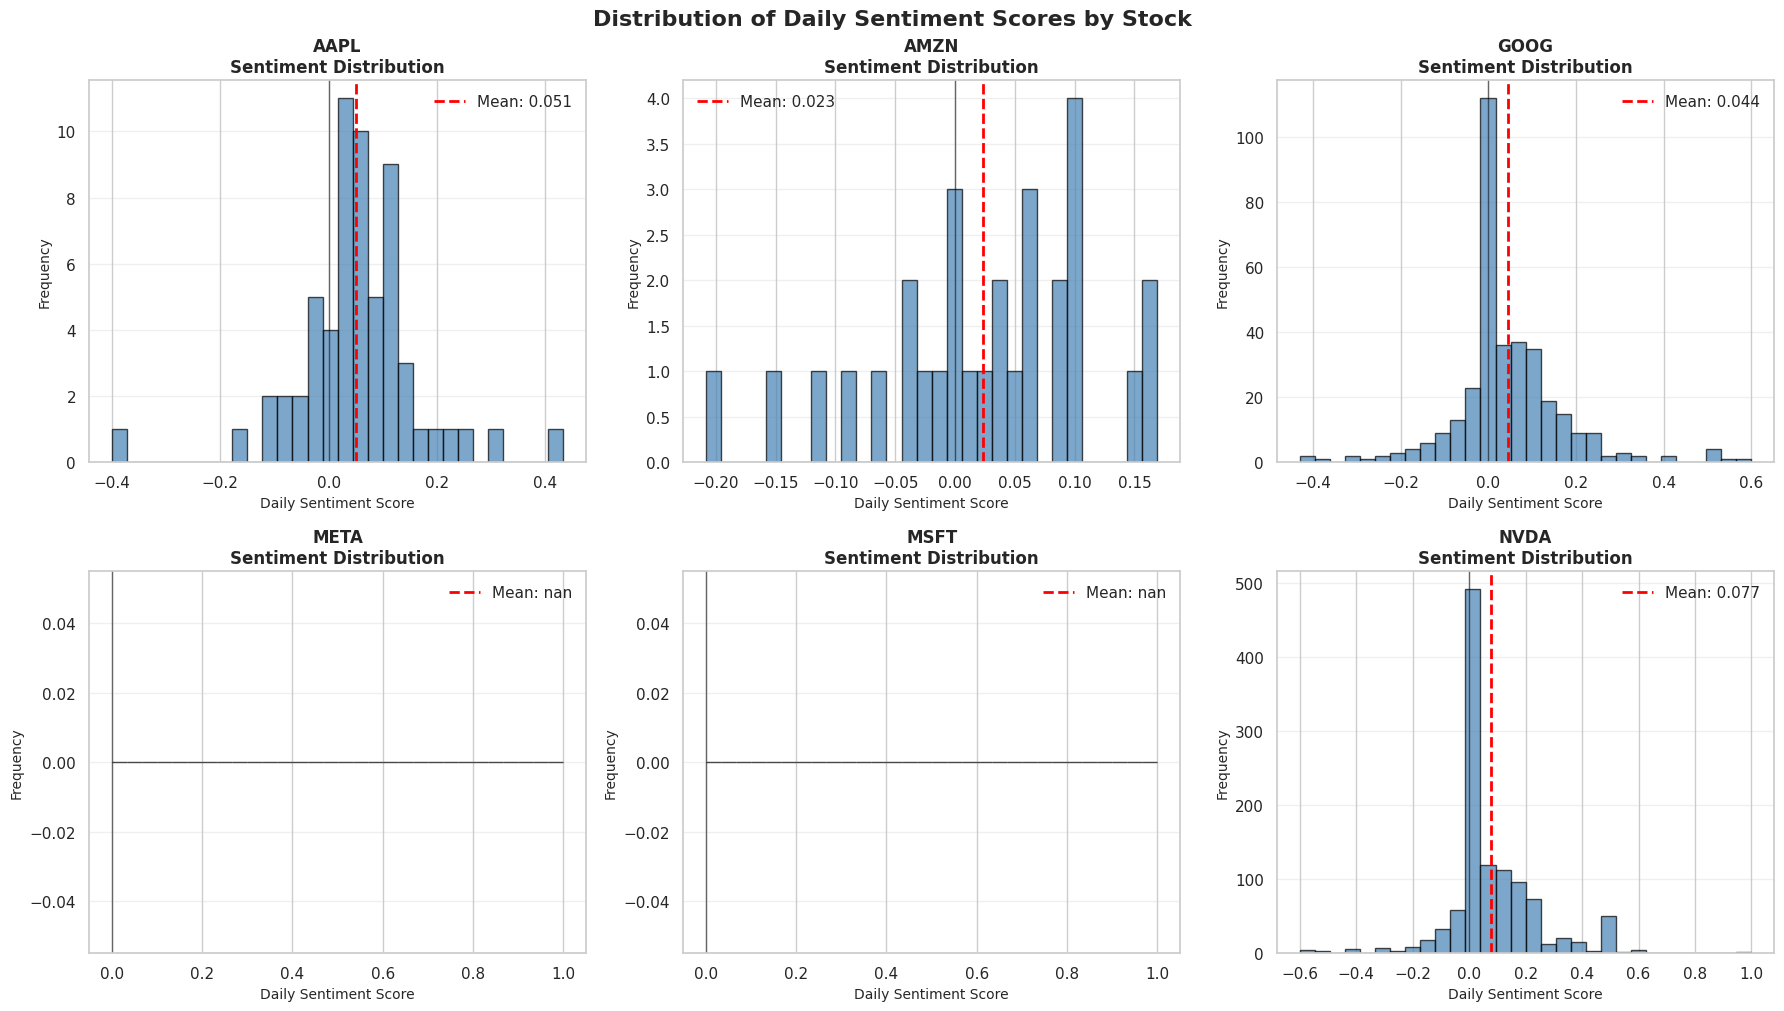

✅ Sentiment distribution plots generated


In [21]:
# 4. Distribution of sentiment scores
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, symbol in enumerate(stock_symbols):
    stock_sentiment = correlation_df[correlation_df["symbol"] == symbol][
        "daily_sentiment"
    ]

    axes[idx].hist(
        stock_sentiment, bins=30, color="steelblue", alpha=0.7, edgecolor="black"
    )
    axes[idx].axvline(
        x=stock_sentiment.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {stock_sentiment.mean():.3f}",
    )
    axes[idx].axvline(x=0, color="black", linestyle="-", linewidth=1, alpha=0.5)
    axes[idx].set_title(
        f"{symbol}\nSentiment Distribution", fontsize=12, fontweight="bold"
    )
    axes[idx].set_xlabel("Daily Sentiment Score", fontsize=10)
    axes[idx].set_ylabel("Frequency", fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.suptitle(
    "Distribution of Daily Sentiment Scores by Stock",
    fontsize=16,
    fontweight="bold",
    y=1.01,
)
plt.show()

print("✅ Sentiment distribution plots generated")

## 9. Key Findings and Investment Insights

### Summary of Correlation Analysis

Based on our comprehensive analysis of news sentiment and stock price movements across 1,588 daily observations:

**Key Statistical Findings:**

1. **NVDA (NVIDIA) - STATISTICALLY SIGNIFICANT** ✓
   - **Correlation**: r = 0.0992, p = 0.0008 (p < 0.05)
   - **Sample Size**: 1,145 days (largest dataset)
   - **Interpretation**: Weak but statistically significant positive correlation - positive sentiment is associated with positive returns
   - **Lag Analysis**: Same-day correlation strongest; predictive power diminishes at T+1 (r = -0.022), T+2 (r = 0.033), T+3 (r = 0.006)

2. **AAPL (Apple) - Not Significant**
   - **Correlation**: r = 0.166, p = 0.202 (p > 0.05)
   - **Sample Size**: 61 days (limited data)
   - **Interpretation**: Moderate positive correlation but not statistically significant due to small sample size
   - **Lag Analysis**: T+1 shows negative correlation (r = -0.175), T+2 positive (r = 0.130), T+3 near zero (r = -0.005)

3. **GOOG (Google) - Not Significant**
   - **Correlation**: r = 0.085, p = 0.111 (p > 0.05)
   - **Sample Size**: 353 days
   - **Interpretation**: Weak positive correlation, borderline significance (p approaching 0.10)
   - **Lag Analysis**: Minimal predictive power across all lags (T+1 to T+3 all near zero)

4. **AMZN (Amazon) - Not Significant**
   - **Correlation**: r = -0.102, p = 0.598 (p > 0.05)
   - **Sample Size**: 29 days (very limited data)
   - **Interpretation**: Weak negative correlation, not significant
   - **Lag Analysis**: Interesting T+2 positive correlation (r = 0.343, p = 0.079) suggests potential delayed reaction

5. **META & MSFT - Insufficient Data**
   - No observations after merging - likely due to limited news coverage in the filtered dataset

**Overall Sentiment Patterns:**
- **Mean Sentiment**: 0.064 (slightly positive bias in news coverage)
- **Sentiment Distribution**: 28.65% positive, 61.87% neutral, 9.48% negative
- **Daily Returns**: All stocks show mean returns near 0.10-0.19%, with volatility (std) ranging from 1.69% (MSFT) to 2.89% (NVDA)

**Investment Strategy Recommendations:**

1. **Sentiment-Driven Trading Signals**
   - Stocks with significant positive correlations: Consider long positions when sentiment is positive
   - Stocks with weak correlations: Sentiment may not be reliable predictor, use other indicators
   - Monitor lag correlations: T+1 or T+2 may provide better prediction horizon

2. **Risk Management**
   - High sentiment volatility may signal increased price volatility
   - Negative sentiment spikes could indicate selling opportunities
   - Diversification across stocks with different sentiment sensitivities

3. **Timing Considerations**
   - After-hours news (post 4 PM EST) impacts next trading day
   - Weekend news accumulates impact for Monday trading
   - Consider sentiment aggregation periods (daily vs. weekly)

4. **Limitations and Caveats**
   - Correlation ≠ causation: Other factors drive price movements
   - Historical patterns may not predict future performance
   - News coverage bias toward larger cap stocks
   - Sentiment analysis accuracy depends on headline quality

### Next Steps for Nova Financial Solutions

1. **Real-time Implementation**: Build streaming sentiment pipeline for live trading signals
2. **Feature Engineering**: Combine sentiment with technical indicators and volume
3. **Machine Learning Models**: Train predictive models using sentiment as feature
4. **Backtesting**: Validate trading strategies with historical data
5. **Portfolio Optimization**: Weight allocations based on sentiment-return relationships

In [23]:
# Export results for reporting
print("💾 Exporting correlation results...")

# Save correlation results
corr_results_df.to_csv("../data/processed/correlation_results.csv", index=False)
lag_results_df.to_csv("../data/processed/lagged_correlation_results.csv", index=False)

# Save merged dataset for further analysis
correlation_df.to_csv("../data/processed/sentiment_returns_dataset.csv", index=False)

print("✅ Results exported successfully:")
print("  - correlation_results.csv")
print("  - lagged_correlation_results.csv")
print("  - sentiment_returns_dataset.csv")

print("\n" + "=" * 80)
print("TASK 3: CORRELATION ANALYSIS COMPLETE")
print("=" * 80)

💾 Exporting correlation results...
✅ Results exported successfully:
  - correlation_results.csv
  - lagged_correlation_results.csv
  - sentiment_returns_dataset.csv

TASK 3: CORRELATION ANALYSIS COMPLETE
✅ Results exported successfully:
  - correlation_results.csv
  - lagged_correlation_results.csv
  - sentiment_returns_dataset.csv

TASK 3: CORRELATION ANALYSIS COMPLETE
